In [1]:
import numpy as np
import pandas as pd
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns

                    
### Note: Pandas may not append all the files.. 

# Run4: All two-visit models
# Run5: All single visit models
# Run6: rerun LSN for single and two visits

In [2]:
project_dir = "../"

run_id_list = ["run_4","run_5","run_6"]

for run_id in run_id_list:
    config_csv = f"{project_dir}results/simulation/configs/config_{run_id}.csv"
    config_df = pd.read_csv(config_csv)
    n_configs = len(config_df)
    print(f"{run_id}, number of configs: {n_configs}")
    
    config_df = config_df.rename(columns={"Unnamed: 0": "config_id"})


run_4, number of configs: 48
run_5, number of configs: 12
run_6, number of configs: 60


## Read results

In [3]:
run_id_list = ["run_4","run_5","run_6"]

perf_df = pd.DataFrame()
for run_id in run_id_list:
    config_csv = f"{project_dir}results/simulation/configs/config_{run_id}.csv"
    config_df = pd.read_csv(config_csv)
    n_configs = len(config_df)
    results_dir = f"{project_dir}results/simulation/{run_id}/"
    for idx in np.arange(n_configs):
        df = pd.read_csv(f"{results_dir}sim_perf_config_{idx}.csv")
        if run_id in ["run_4","run_5"]:
            df = df[df["model"].isin(["Ridge","RF"])]
        df["config_id"] = idx
        perf_df = perf_df.append(df)

perf_df.shape

(1498500, 21)

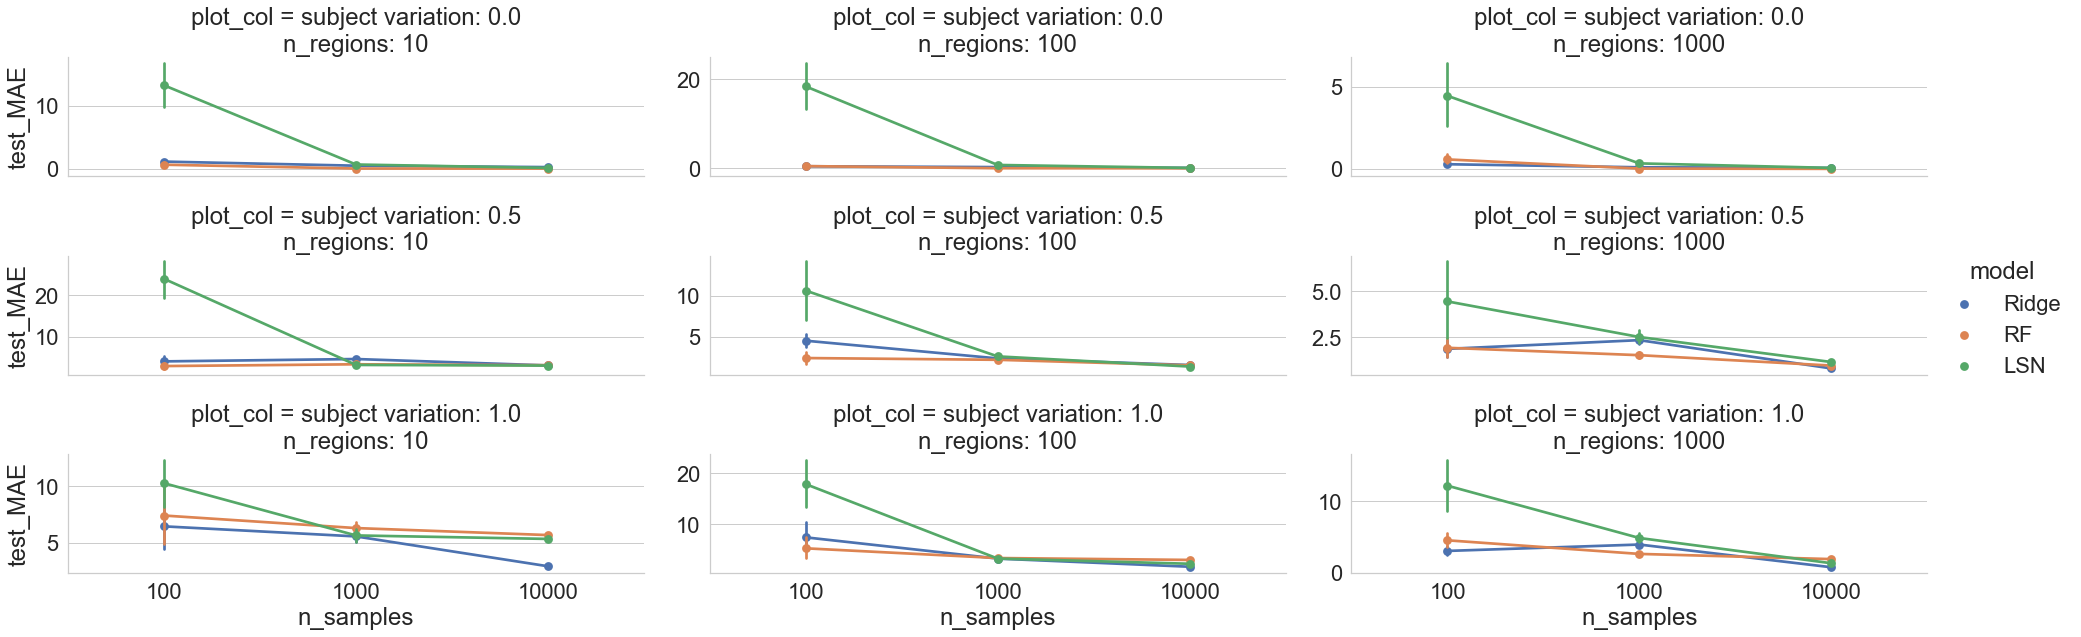

In [4]:
plot_df = perf_df.copy()

traj_func = "exp"
roi_variation = "init_shift"
followup_interval = 2
data_aug = False

plot_df = plot_df[(plot_df["traj_func"]==traj_func) & (plot_df["roi_variation"]==roi_variation) & (plot_df["data_aug"] == data_aug)] 
plot_df = plot_df[(plot_df["followup_interval"]==followup_interval)]

if followup_interval > 0:
    plot_df["test_MAE"] = 0.5 * (plot_df["test_MAE1"] + plot_df["test_MAE1"])
    plot_df["test_r"] = 0.5 * (plot_df["test_r1"] +plot_df["test_r1"])
else:
    plot_df["test_MAE"] = plot_df["test_MAE1"]
    plot_df["test_r"] = plot_df["test_r1"] 

plot_df["plot_col"] = "subject variation: " + plot_df["subject_variation"].astype(str) + "\nn_regions: " + plot_df["n_regions"].astype(str)

sns.set(font_scale=2)
with sns.axes_style("whitegrid"):
    g = sns.catplot(y="test_MAE",x="n_samples",hue="model",col="plot_col", col_wrap=3, height=3, aspect=3, kind="point", 
                    sharey=False, data=plot_df)

## Vector similarity

In [23]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial import distance

chrno_age = perf_df[["test_age_1","test_age_2"]].values
brain_age = perf_df[["test_brainage_1","test_brainage_2"]].values

sim_list = []
for i in range(len(chrno_age)):
    cos_sim = 1 - distance.cosine(chrno_age[i],brain_age[i])
    sim_list.append(cos_sim)



/home/nikhil/projects/green_comp_neuro/green_compute/lib/python3.7/site-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


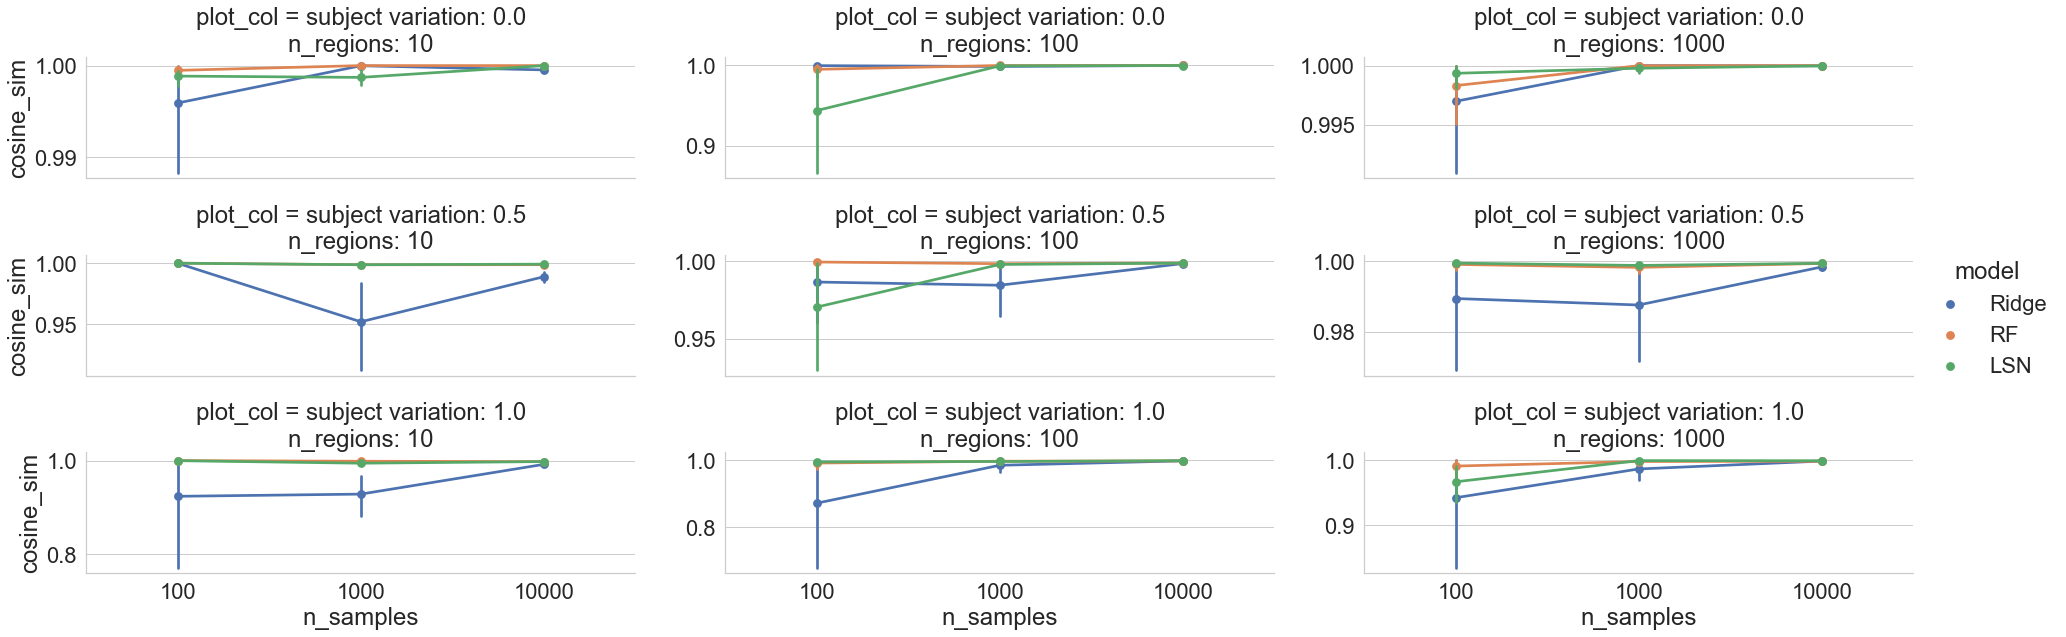

In [24]:
plot_df = perf_df.copy()
plot_df["cosine_sim"] = sim_list

traj_func = "exp"
roi_variation = "init_shift"
followup_interval = 2
data_aug = False

plot_df = plot_df[(plot_df["traj_func"]==traj_func) & (plot_df["roi_variation"]==roi_variation) & (plot_df["data_aug"] == data_aug)] 
plot_df = plot_df[(plot_df["followup_interval"]==followup_interval)]


plot_df["plot_col"] = "subject variation: " + plot_df["subject_variation"].astype(str) + "\nn_regions: " + plot_df["n_regions"].astype(str)

sns.set(font_scale=2)
with sns.axes_style("whitegrid"):
    g = sns.catplot(y="cosine_sim",x="n_samples",hue="model",col="plot_col", col_wrap=3, height=3, aspect=3, kind="point", 
                    sharey=False, data=plot_df)

## Brainage diff

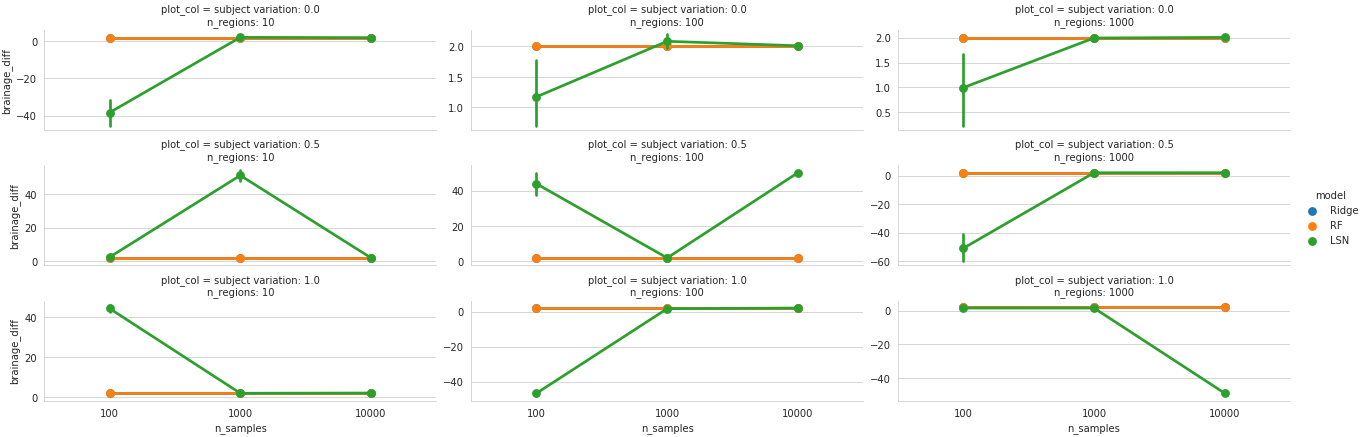

In [71]:
plot_df["brainage_diff"] = plot_df["test_brainage_2"] - plot_df["test_brainage_1"]

with sns.axes_style("whitegrid"):
    g = sns.catplot(y="brainage_diff",x="n_samples",hue="model",col="plot_col", col_wrap=3, height=2, aspect=3, kind="point", 
                    sharey=False, data=plot_df)

## Effect of data aug

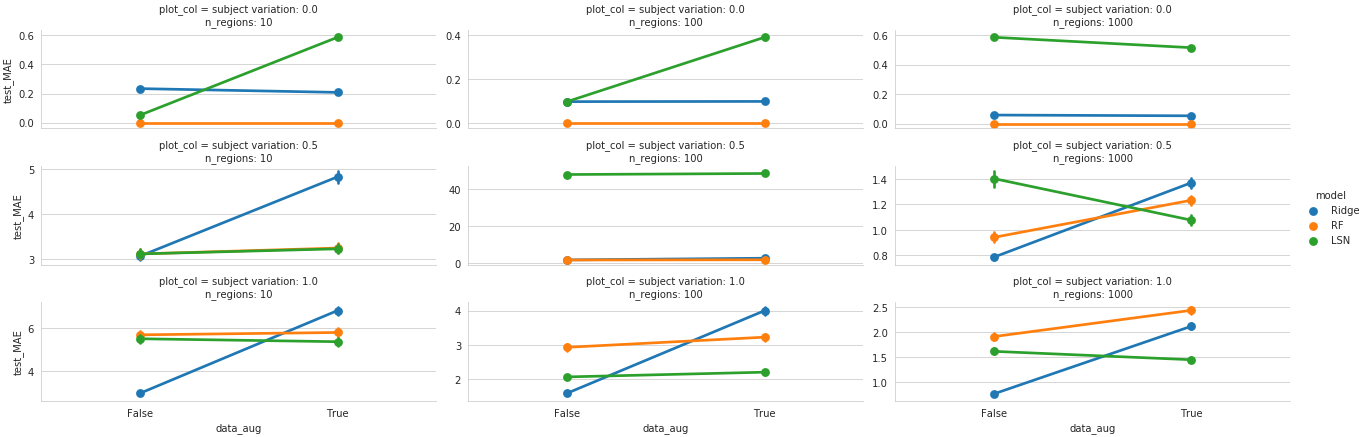

In [79]:
plot_df = perf_df.copy()

traj_func = "exp"
roi_variation = "init_shift"
followup_interval = 2

plot_df = plot_df[(plot_df["traj_func"]==traj_func) & (plot_df["roi_variation"]==roi_variation)] 
plot_df = plot_df[(plot_df["followup_interval"]==followup_interval)]
plot_df = plot_df[(plot_df["n_samples"]==10000)]

plot_df["test_MAE"] = 0.5 * (plot_df["test_MAE1"] + plot_df["test_MAE1"])
plot_df["test_r"] = 0.5 * (plot_df["test_r1"] +plot_df["test_r1"])

plot_df["plot_col"] = "subject variation: " + plot_df["subject_variation"].astype(str) + "\nn_regions: " + plot_df["n_regions"].astype(str)


with sns.axes_style("whitegrid"):
    g = sns.catplot(y="test_MAE",x="data_aug",hue="model",col="plot_col", col_wrap=3, height=2, aspect=3, kind="point", 
                    sharey=False, data=plot_df)

## Generate run configs:

In [61]:
traj_func_list = ["exp", "poly"]
roi_variation_list = ["init_shift", "time_shift"]
subject_variation_list = [0, 0.5, 1]
followup_list = [0, 2, 10]
data_aug_list = [False, True]

config_df = pd.DataFrame(columns=["traj_func","roi_variation","subject_variation","followup_interval","data_aug"])

i = 0
for traj_func in traj_func_list:
    for roi_variation in roi_variation_list:
        for subject_variation in subject_variation_list:
            for followup_interval in followup_list:
                if followup_interval > 0: 
                    for data_aug in data_aug_list:        
                        config_df.loc[i] = [traj_func, roi_variation, subject_variation, followup_interval, data_aug]
                        i += 1
                else:
                    data_aug = False
                    config_df.loc[i] = [traj_func, roi_variation, subject_variation, followup_interval, data_aug]
                    i += 1


print(f"n_configs: {len(config_df)}")
config_df.head()

n_configs: 60


,traj_func,roi_variation,subject_variation,followup_interval,data_aug
0,exp,init_shift,0,0,False
1,exp,init_shift,0,2,False
2,exp,init_shift,0,2,True
3,exp,init_shift,0,10,False
4,exp,init_shift,0,10,True


In [62]:
## Save config file
# config_df.to_csv("./results/simulation/configs/config_run_6.csv")

## Cosine similarity and brain age

In [39]:
c_age = [25, 50]
b_age = [50, 25]

cos_sim = 1 - distance.cosine(c_age,b_age)
cos_sim

0.8